# Homework 2
Jonathan Elsner \
AMATH 505

In [196]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pint
import pint_pandas

I'm using a library called [pint](https://pint.readthedocs.io/en/stable/index.html) to manage units. It's really convenient once you get it all set up.

In [197]:
units = pint_pandas.PintType.ureg
units.setup_matplotlib()

Let's declare some constants that we'll need in all sections.

In [198]:
water_density = 997 * units.kg / units.m**3
g = 9.81 * units.m / units.s**2 # Gravity
nu_water = 1e-6 * units.m**2 / units.s # Kinematic viscosity of water
mu_water = nu_water * water_density # Dynamic viscosity of water (since kinematic viscosity = dynamic viscosity / density)

R_pipe = 12 / 2 * units.mm # Pipe radius
l_pipe = 151 * 2 * units.cm # Pipe length (estimated to be double length between pressure gauges)


## Transition to turbulent flow in a pipe

### Question 1

Turbulent flow is characterized by much swirling of the dye, and speedy diffusion of the tracer to become evenly mixed within the water. Laminar flow is characterized by smooth, straight paths taken by the tracer, with slow diffusion, so that even far down the pipe, the tracer is identifiably separate from the rest of the water.

### Question 2


First let's do some munging of the data collected in lab.

In [199]:
data = pd.read_csv('./lab2-data.csv',
                       usecols=['Volume (mL)', 'Time (s)', 'Pressure difference (mm)', 'Qualatative Analysis'],
                       header=0,
                    #    dtype={'Volume (mL)': 'pint[mL]', 'Time (s)': 'pint[s]', 'Pressure difference (mm)': 'pint[mm]'}
                       )
data.rename(columns={'Volume (mL)': 'volume', 'Time (s)': 'time', 'Pressure difference (mm)': 'height_difference'}, inplace=True)

In [200]:
data.loc[0, 'time'] = 0 # Set 0 flow to 0 time

In [201]:
# Add units to each column of data
data = data.astype({'volume': 'pint[mL]', 'time': 'pint[s]', 'height_difference': 'pint[mm]'})
data

,volume,time,height_difference,Qualatative Analysis
0,0,0.0,2,I mean the water isn't moving.
1,230,60.0,3,mostly laminar
2,225,30.0,5,"some turbulence, diffuses quickly"
3,400,15.0,15,much turbulence
4,650,15.0,20,much turbulence
5,700,10.0,60,much turbulence


Now we calculate the volume transport from the volume of water measured over the amount of time it was collected.

In [202]:
data['volume_transport'] = (data['volume'] / data['time']).pint.to('mL/s')
data.loc[0, 'volume_transport'] = 0 # set transport for 0 time
# data['volume_transport']

We can also calculate the mean velocity of the water through the pipe for each flow rate.

In [203]:
data['mean_vel'] = (data['volume_transport'] / (np.pi * R_pipe**2)).pint.to('mm/s')
# data['mean_vel']

And finally with the mean velocity we can calculate Reynold's number.

In [204]:
data['reynolds_number'] = (2 * R_pipe * data['mean_vel'] / nu_water).pint.to('dimensionless')
# data['reynolds_number']

Let's look at the computed data.

In [205]:
data[['height_difference', 'volume_transport', 'mean_vel', 'reynolds_number', 'Qualatative Analysis']]

,height_difference,volume_transport,mean_vel,reynolds_number,Qualatative Analysis
0,2,0.0,0.0,0.0,I mean the water isn't moving.
1,3,3.8333333333333335,33.89410825105179,406.7292990126215,mostly laminar
2,5,7.5,66.31455962162305,795.7747154594765,"some turbulence, diffuses quickly"
3,15,26.666666666666668,235.785100876882,2829.4212105225843,much turbulence
4,20,43.333333333333336,383.15078892493324,4597.8094670991995,much turbulence
5,60,70.0,618.9358898018153,7427.230677621783,much turbulence


The flow is laminar for small Reynold's number and turbulent for large Reynold's number. I found that the flow was becoming more turbulent for a Reynold's number of 795.7 (the 2nd indexed row).

### Question 3

The regions that remain relatively laminar even for high Reynold's numbers were those near the walls of the pipe. In the lab, we observed that tracer injected into the stream close to the pipe flowed in smooth lines much longer than it did when injected at the center of the pipe, even for high mean fluid velocities. This makes sense, because the fluid velocity near the pipe wall is slower due to viscous forces, and we would expect locally that the Reynold's number is smaller and therefore there is less turbulence.



## Poiseuille Flow in a pipe



### Part 1

Beginning with:
$$AP_1 - AP_2 - F_\text{visc} = 0 $$

and taking $ \Delta P = P_1 - P_2$,

$$
\begin{split}
\pi r^2 \Delta P + \mu \frac{\partial u}{\partial r} 2 \pi L r &= 0 \\
\mu 2 \pi L r \frac{\partial u}{\partial r} &= - \Delta P r \\
\frac{\partial u}{\partial r} &= - \frac{\Delta P}{2 \mu L} r \\
\int_0^s \frac{\partial u}{\partial r} &= - \frac{\Delta P}{2 \mu L} \int_0^s r dr \\
u(r) \Big|_0^s &= - \frac{\Delta P}{4 \mu L} r^2 \Big|_0^s \\
u(s) - u(0) &= -\frac{\Delta P}{4 \mu L} s^2 \\
\end{split}
$$
Setting $u(R) = 0$ because velocity is zero at the pipe wall,
$$
\begin{split}
0 - u(0) &= -\frac{\Delta P}{4 \mu L} R^2 \\
u_c = u(0) &= \frac{\Delta P}{4 \mu L} s^2
\end{split}
$$
Then solving our original derivation for $u(s)$:
$$
\begin{split}
u(s) &= \frac{\Delta P}{4 \mu L} R^2 - \frac{\Delta P}{4 \mu L} s^2 \\
u(s) &= \frac{\Delta P}{4 \mu L} (R^2 - s^2)\quad s \in [0, R]\\
\end{split}
$$

Using our derived function of velocity, we can integrate over the cross section of the pipe to calculate the ideal flow rate $Q$ through the pipe for different pressure differences.

$$\begin{split}
Q &= \int \int u(s)\ dA \\
&= \int_0^{2 \pi} \int_0^R u(r) r\ dr\ d\theta \\
&= \int_0^{2 \pi}d\theta \int_0^R \frac{\Delta P}{4 \mu L}(R^2 - r^2) r\ dr \\
&= 2 \pi \frac{\Delta P}{4 \mu L} \left[\frac{R^4}{2} - \frac{r^4}{4}\right]_0^R \\
&= \frac{\pi \Delta P}{2 \mu L} \left(\frac{R^4}{2} - \frac{R^4}{4}\right) \\
Q &= \frac{\pi R^4}{8 \mu L} \Delta P
\end{split}$$

Putting this in terms of $\Delta P$, we get:

$$ \Delta P = \frac{8 \mu L Q}{\pi R^4} $$

and substituting this back into our ...

<font color=red>TODO: finish this. I don't really know what's wanted for a *velocity profile* </font>



### Part 2

I expect the Poiseuille idealization to work well for small pressure differences between the ends of the pipe. This is because at low pressure differences, the water speed will be low, and therefore flow will mostly be laminar. At higher pressures (and therefore speeds), Reynold's number will be higher, indicating more turbulent flow where volume transport is lower than the theoretical maximum due to increased viscous forces.

### Part 3


Now let's perform these calculations!

Compute the change in pressure within the pipe using hydrostatic bounds and the measured difference in water head height at each gauge.

In [206]:
data['pressure_drop'] = (data['height_difference'] * water_density * g).pint.to('Pa')
# data['pressure_drop']

In [207]:
# Volume transport Q
def Q(delta_P):
    return delta_P * np.pi * R_pipe**4 / (8 * mu_water * l_pipe)

In [208]:
data['predicted_transport'] = Q(data['pressure_drop']).pint.to('L/s')
data[['pressure_drop', 'volume_transport', 'predicted_transport']]

,pressure_drop,volume_transport,predicted_transport
0,19.561139999999998,0.0,0.003306411839031769
1,29.341710000000003,3.8333333333333335,0.004959617758547656
2,48.90285000000001,7.5,0.008266029597579426
3,146.70855000000003,26.666666666666668,0.024798088792738277
4,195.61140000000003,43.333333333333336,0.033064118390317705
5,586.8342000000001,70.0,0.09919235517095311


Plotting both the actual flow rate and the predicted flow rate versus pressure difference, we get:

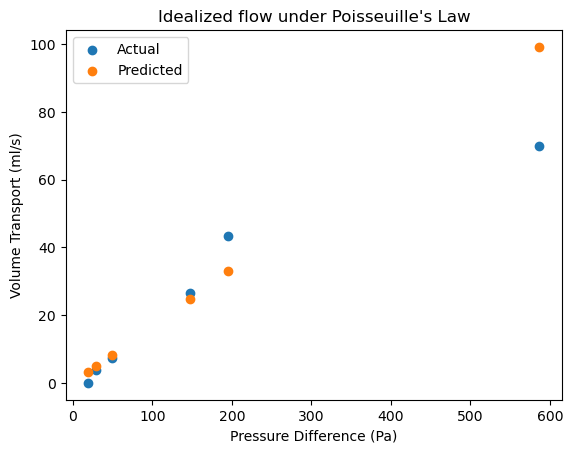

In [209]:
fig, ax = plt.subplots()

ax.scatter(data.pressure_drop, data.volume_transport, label='Actual')
ax.scatter(data.pressure_drop, data.predicted_transport, label='Predicted')

ax.set_title("Idealized flow under Poisseuille's Law")
ax.set_xlabel(f'Pressure Difference ({data.pressure_drop.pint.units:~P})')
ax.set_ylabel(f'Volume Transport ({data.volume_transport.pint.units:~P})')
ax.legend()
plt.show()

### Part 4

The large discrepancy between predicted and actual flow rates at large pressure differences is expected due to turbulent flow. Turbulent flow makes the streamlines longer, subjecting the water to greater viscosity forces, slowing it down and therefore reducing transport volume. This effect is greater for higher pressure differences when Reynold's number is higher. As we see below, the Poisseuille model is a better predicter of flow rate when Reynold's number is small: lower than what is considered turbulent for water.

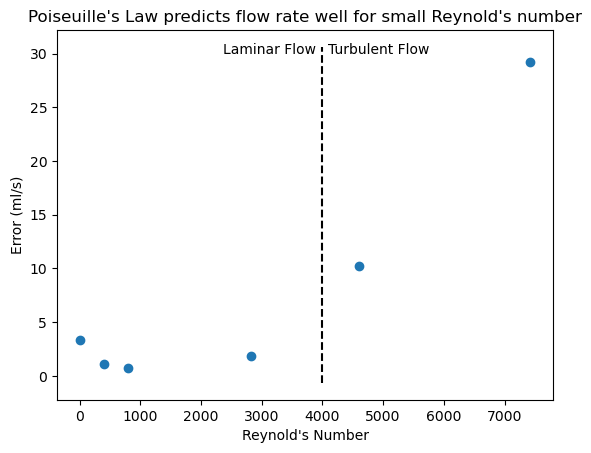

In [217]:
ax = plt.gca()
error = np.abs(data.predicted_transport - data.volume_transport).pint.to('mL/s')
ax.scatter(data.reynolds_number, error)

ax.vlines(4000, *ax.get_ylim(), linestyles='dashed', color='black')
ax.text(4100, 30, 'Turbulent Flow')
ax.text(3900, 30, 'Laminar Flow', horizontalalignment='right')

ax.set_title("Poiseuille's Law predicts flow rate well for small Reynold's number")
ax.set_xlabel("Reynold's Number")
ax.set_ylabel(f"Error ({error.pint.units:~P})")

plt.show()

<font size=1>Don't look at the relative error; there's nothing to see there.</font>

# Extra thing

I plotted radius versus transport velocity in a pretty way.

In [211]:
# Water velocity u
def u(r, delta_P=1*units.Pa):
    return delta_P / (4 * mu_water * l_pipe) * (R_pipe**2 - r**2)

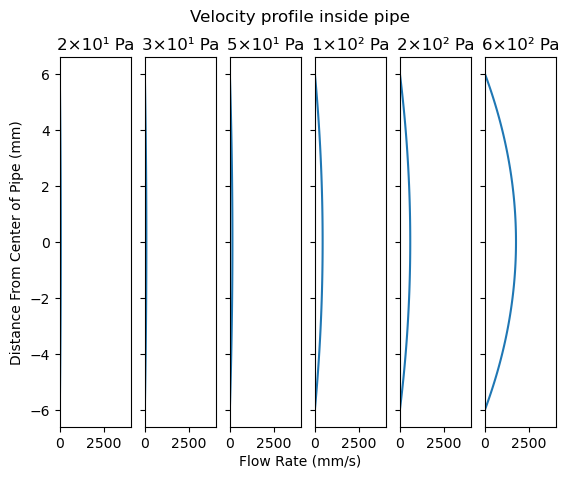

In [212]:
r = np.linspace(-R_pipe, R_pipe, 100)

fig, axes = plt.subplots(ncols=len(data), sharey=True)
for delta_P, ax in zip(data['pressure_drop'].pint.tolist(), axes):
    ax.set_xlim(0, 4000)
    ax.plot(u(r, delta_P=delta_P).to('mm/s'), r)
    ax.set_xlabel('') # Necessary because pint adds x labels that overlap
    ax.set_title(f'{delta_P:0.1#~P}')

axes[0].set_ylabel(f'Distance From Center of Pipe ({R_pipe.units:~P})')
fig.suptitle('Velocity profile inside pipe')
fig.text(0.5, 0.03, 'Flow Rate (mm/s)', ha='center')


plt.show()

This makes a lot of sense when you think of the pipe running from left to right. The water in the middle of the pipe moves further in the same amount of time than the edges. The difference in speed between the center and walls is more pronounced for higher pressures.